# **Authorize Drive and set up pre-environments**

In [1]:
# Mount and authorize Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Make sure the necessary packages are installed
!pip install --quiet --upgrade torch torchvision matplotlib seaborn scikit-learn tqdm pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 118.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 107.1 MB/s eta 0:00:00


In [9]:
# Loading Kit
import random
import os
import shutil
from PIL import Image
import pandas as pd
import numpy as np
import torch
from torchvision import transforms as tfs
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset,DataLoader
from torchvision import transforms
from torch.utils.data import random_split
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchvision import models
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, f1_score,accuracy_score,precision_score,confusion_matrix,classification_report
from sklearn.utils.class_weight import compute_class_weight

In [4]:
# Setting up training equipment
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# **Construction data collection**

In [5]:
# Unzip Aerial_Landscapes.zip
import zipfile
import os

# Path to the compressed file
zip_path = '/content/drive/MyDrive/Aerial_Landscapes.zip'
extract_path = '/content/aerial_data'

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipping complete!")


Unzipping complete!


In [6]:
# Split into train / val / test folders
import shutil
from sklearn.model_selection import train_test_split

# Assume that the folder after decompression is extract_path, which contains the folders of each type of image
source_dir = os.path.join(extract_path, 'Aerial_Landscapes')
split_root = '/content/split_data'

for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [img for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]

    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for split, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
        split_dir = os.path.join(split_root, split, class_name)
        os.makedirs(split_dir, exist_ok=True)
        for img in split_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(split_dir, img))

print("Dataset splitting completed！")

Dataset splitting completed！


In [7]:
# Read the data set and create a data table
def create_df(root):
    label = 0
    label_list = []
    filepath_list = []
    class_list = []

    for class_name in sorted(os.listdir(root)):
        class_path = os.path.join(root, class_name)
        if not os.path.isdir(class_path):
            continue

        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)
            filepath_list.append(image_path)
            class_list.append(class_name)
            label_list.append(label)
        label += 1

    return pd.DataFrame({
        "filename": filepath_list,
        "class": class_list,
        "label": label_list
    })

df_train = create_df('/content/split_data/train')
df_val = create_df('/content/split_data/val')
df_test = create_df('/content/split_data/test')

print("Create df successfully！")
df_train.head()


Create df successfully！


,filename,class,label
0,/content/split_data/train/Agriculture/180.jpg,Agriculture,0
1,/content/split_data/train/Agriculture/636.jpg,Agriculture,0
2,/content/split_data/train/Agriculture/472.jpg,Agriculture,0
3,/content/split_data/train/Agriculture/678.jpg,Agriculture,0
4,/content/split_data/train/Agriculture/773.jpg,Agriculture,0


In [20]:
# Calculating Class Weights

# Get the labels of all training sets
all_labels = df_train['label'].to_numpy()

# Get the labels of all training sets
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)

# Convert to PyTorch Tensor and throw it to GPU
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [21]:
# Define image preprocessing
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean, std)

resize_H, resized_W = 224,224
resize = transforms.Resize([resize_H, resized_W])

transformations_train = transforms.Compose([resize,
                                    tfs.RandomHorizontalFlip(0.2),
                                    tfs.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5),
                                    transforms.ToTensor(),
                                    transforms.RandomAffine(0, None, (0.7, 1.1), (0, 30),fill=(127,127,127)),
                                    normalize])
transformations_test = transforms.Compose([resize,
                                    transforms.ToTensor(),
                                    normalize])

In [22]:
# Convert image to Tensor
from torch.utils.data import Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['filename']
        label = self.dataframe.iloc[idx]['label']

        # Open the image and convert it to RGB
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


In [23]:
# Create Dataset
train_dataset = ImageDataset(df_train, transformations_train)
val_dataset = ImageDataset(df_val, transformations_test)
test_dataset = ImageDataset(df_test, transformations_test)

# Create DataLoader (automatic batch loading)
batch_size = 64
num_workers = 2  # You can set it smaller according to RAM

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


# **RESNET**-18

In [24]:
# Model 1: ResNet18
net = models.resnet18(pretrained=True)
net.fc =  nn.Linear(net.fc.in_features,15)

net.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
my_lr= 1e-4
bs= batch_size
epochs = 10

optimizer = torch.optim.Adam(net.parameters(), lr=my_lr)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
# Model training loop (ResNet18)
def train_model():
    train_loss, valid_loss = [], []
    train_acc, valid_acc = [], []
    for epoch in range(epochs):
        net.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == target).sum().item()
            total_train += target.size(0)

        train_loss_epoch = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_loss.append(train_loss_epoch)
        train_acc.append(train_accuracy)

        net.eval()
        all_preds = []
        all_labels = []
        running_valid_loss = 0.0
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_loader):
                data, target = data.to(device), target.to(device)
                outputs = net(data)
                loss = criterion(outputs, target)

                preds = torch.argmax(outputs, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(target.cpu().numpy())

                running_valid_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_valid += (predicted == target).sum().item()
                total_valid += target.size(0)

        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')
        valid_loss_epoch = running_valid_loss / len(val_loader)
        valid_accuracy = correct_valid / total_valid
        valid_loss.append(valid_loss_epoch)
        valid_acc.append(valid_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss_epoch:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Valid Loss: {valid_loss_epoch:.4f}, Valid Accuracy: {valid_accuracy:.4f}, "
              f"Recall: {recall:.4f}, F1-score: {f1:.4f}")
if __name__ == "__main__":
    train_model()


Epoch [1/10], Train Loss: 2.3740, Train Accuracy: 0.2201, Valid Loss: 1.7097, Valid Accuracy: 0.3911, Recall: 0.3911, F1-score: 0.3849
Epoch [2/10], Train Loss: 1.3781, Train Accuracy: 0.5348, Valid Loss: 1.1571, Valid Accuracy: 0.6256, Recall: 0.6256, F1-score: 0.6153
Epoch [3/10], Train Loss: 0.9307, Train Accuracy: 0.6974, Valid Loss: 1.4892, Valid Accuracy: 0.5639, Recall: 0.5639, F1-score: 0.5375
Epoch [4/10], Train Loss: 0.7079, Train Accuracy: 0.7700, Valid Loss: 1.7127, Valid Accuracy: 0.4756, Recall: 0.4756, F1-score: 0.4832
Epoch [5/10], Train Loss: 0.5689, Train Accuracy: 0.8133, Valid Loss: 1.4822, Valid Accuracy: 0.5683, Recall: 0.5683, F1-score: 0.5279
Epoch [6/10], Train Loss: 0.4802, Train Accuracy: 0.8473, Valid Loss: 0.9196, Valid Accuracy: 0.7111, Recall: 0.7111, F1-score: 0.6989
Epoch [7/10], Train Loss: 0.3963, Train Accuracy: 0.8724, Valid Loss: 2.2969, Valid Accuracy: 0.4011, Recall: 0.4011, F1-score: 0.3750
Epoch [8/10], Train Loss: 0.3578, Train Accuracy: 0.881

In [26]:
# Test model (ResNet18)
# Set the model to evaluation mode
net.eval()

# Initialize variables for test evaluation
all_preds = []
all_labels = []
running_test_loss = 0.0
correct_test = 0
total_test = 0

# Loop through the test data and calculate predictions
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        outputs = net(data)
        loss = criterion(outputs, target)

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

        running_test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == target).sum().item()
        total_test += target.size(0)

# Calculate metrics
test_loss = running_test_loss / len(test_loader)
test_accuracy = correct_test / total_test
test_recall = recall_score(all_labels, all_preds, average='macro')
test_f1 = f1_score(all_labels, all_preds, average='macro')

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Print results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}")
print(f"Confusion Matrix:\n{cm}")
print(f"Classification Report:\n{classification_report(all_labels, all_preds, digits=4)}")

Test Loss: 4.9838, Test Accuracy: 0.3000
Test Recall: 0.3000
Test F1-score: 0.2647
Confusion Matrix:
[[ 37   0  50   0   0   0   0   0   0   0   0   0  33   0   0]
 [  0   3  30   0   0   0   0   0   0   0   0   0  87   0   0]
 [  0   0 114   0   0   0   0   0   0   0   0   0   6   0   0]
 [  0   0   9   5   0   0   0   0   0   7   0   1  98   0   0]
 [  0   0  51   0  69   0   0   0   0   0   0   0   0   0   0]
 [  0   0  89   0   7   2   1   0   0   2   0   0  19   0   0]
 [  0   0 115   0   1   0   0   0   0   0   0   0   4   0   0]
 [  0   0  29   0   0   0   0  15   0   0   0   0  76   0   0]
 [  2   0  65   0   0   0   0   0   2   0   0   1  49   0   1]
 [  0   0  79   0   4   0   0   0   0  12   0   0  25   0   0]
 [  0   0   1   0   0   0   0  10   0   0  93   0  16   0   0]
 [  0   0  12   0   0   0   0   2   0   0   5  62  39   0   0]
 [  0   0   6   0   0   0   0   0   0   0   0   0 114   0   0]
 [  0   2  11   1   0   0   0   1   0   1   0   0 103   1   0]
 [  0   0  78   0

In [27]:
# Save the ResNet's results into variables and finally draw a comparison picture
resnet_test_results = {
    'name': 'ResNet18',
    'accuracy': test_accuracy,
    'recall': test_recall,
    'f1': test_f1,
    'loss': test_loss
}

# **Efficientnet_b0**

In [28]:
# Model 2: EfficientNet-B0
net = models.efficientnet_b0(pretrained=True)

net.classifier[1] = nn.Linear(net.classifier[1].in_features, 15)


net.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
my_lr = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=my_lr)

epochs = 10

train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

for epoch in range(epochs):
    net.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = net(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == target).sum().item()
        total_train += target.size(0)

    train_loss_epoch = running_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_loss.append(train_loss_epoch)
    train_acc.append(train_accuracy)


    net.eval()
    all_preds = []
    all_labels = []
    running_valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            outputs = net(data)
            loss = criterion(outputs, target)

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

            running_valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_valid += (predicted == target).sum().item()
            total_valid += target.size(0)

    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    valid_loss_epoch = running_valid_loss / len(val_loader)
    valid_accuracy = correct_valid / total_valid
    valid_loss.append(valid_loss_epoch)
    valid_acc.append(valid_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss_epoch:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Valid Loss: {valid_loss_epoch:.4f}, Valid Accuracy: {valid_accuracy:.4f}, "
          f"Recall: {recall:.4f}, F1-score: {f1:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 143MB/s]


Epoch [1/10], Train Loss: 2.2994, Train Accuracy: 0.2663, Valid Loss: 1.5018, Valid Accuracy: 0.5189, Recall: 0.5189, F1-score: 0.5012
Epoch [2/10], Train Loss: 1.3339, Train Accuracy: 0.5698, Valid Loss: 0.8052, Valid Accuracy: 0.7550, Recall: 0.7550, F1-score: 0.7523
Epoch [3/10], Train Loss: 0.9509, Train Accuracy: 0.6914, Valid Loss: 0.5612, Valid Accuracy: 0.8278, Recall: 0.8278, F1-score: 0.8287
Epoch [4/10], Train Loss: 0.7158, Train Accuracy: 0.7737, Valid Loss: 0.4996, Valid Accuracy: 0.8356, Recall: 0.8356, F1-score: 0.8370
Epoch [5/10], Train Loss: 0.5934, Train Accuracy: 0.8075, Valid Loss: 0.3607, Valid Accuracy: 0.8911, Recall: 0.8911, F1-score: 0.8906
Epoch [6/10], Train Loss: 0.5000, Train Accuracy: 0.8381, Valid Loss: 0.6413, Valid Accuracy: 0.7817, Recall: 0.7817, F1-score: 0.7828
Epoch [7/10], Train Loss: 0.4353, Train Accuracy: 0.8575, Valid Loss: 0.2604, Valid Accuracy: 0.9244, Recall: 0.9244, F1-score: 0.9241
Epoch [8/10], Train Loss: 0.3805, Train Accuracy: 0.874

In [29]:
# Test model (EfficientNet-B0)
# Set the model to evaluation mode
net.eval()

# Initialize variables for test evaluation
all_preds = []
all_labels = []
running_test_loss = 0.0
correct_test = 0
total_test = 0

# Loop through the test data and calculate predictions
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        outputs = net(data)
        loss = criterion(outputs, target)

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

        running_test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == target).sum().item()
        total_test += target.size(0)

# Calculate metrics
test_loss = running_test_loss / len(test_loader)
test_accuracy = correct_test / total_test
test_recall = recall_score(all_labels, all_preds, average='macro')
test_f1 = f1_score(all_labels, all_preds, average='macro')

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Print results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}")
print(f"Confusion Matrix:\n{cm}")
print(f"Classification Report:\n{classification_report(all_labels, all_preds, digits=4)}")

Test Loss: 0.2283, Test Accuracy: 0.9322
Test Recall: 0.9322
Test F1-score: 0.9321
Confusion Matrix:
[[113   2   0   0   0   0   3   0   0   1   0   0   0   0   1]
 [  1 108   0   3   0   0   0   0   0   0   0   0   7   0   1]
 [  0   0 118   1   0   0   0   0   0   0   0   0   0   0   1]
 [  0   0   0 115   0   0   0   0   0   0   0   1   4   0   0]
 [  1   0   2   2  96   0   1   0   2  16   0   0   0   0   0]
 [  0   1   0   0   0 114   2   0   1   0   0   1   0   1   0]
 [  5   0   0   0   1   2 108   0   1   0   0   0   0   0   3]
 [  0   2   0   0   0   0   0 113   0   0   0   0   3   1   1]
 [  3   0   1   0   0   0   1   0 111   0   0   0   0   0   4]
 [  1   1   0   0   1   1   0   1   0 109   0   0   0   0   6]
 [  0   0   1   1   0   0   0   0   0   0 117   1   0   0   0]
 [  1   1   2   0   0   0   0   0   1   0   0 115   0   0   0]
 [  0   4   0   1   0   0   0   1   0   0   0   0 114   0   0]
 [  0   0   0   2   0   0   0   0   0   0   0   0   0 118   0]
 [  3   0   1   0

In [30]:
# Save the Efficientnet's results into variables and finally draw a comparison picture
efficientnet_test_results = {
    'name': 'EfficientNetB0',
    'accuracy': test_accuracy,
    'recall': test_recall,
    'f1': test_f1,
    'loss': test_loss
}

# **Comparative picture**

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


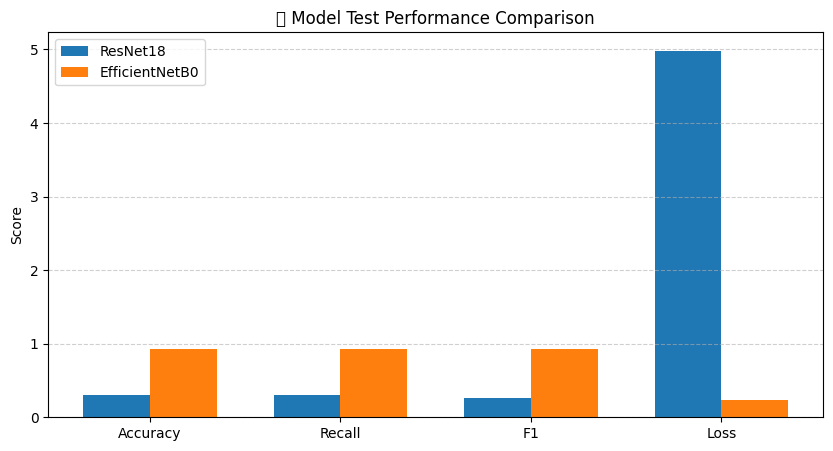

In [31]:
# Plotting to compare the effectiveness of two models
def plot_test_metrics(resnet_results, efficientnet_results):
    metrics = ['accuracy', 'recall', 'f1', 'loss']
    resnet_values = [resnet_results[m] for m in metrics]
    effnet_values = [efficientnet_results[m] for m in metrics]

    x = range(len(metrics))
    plt.figure(figsize=(10, 5))
    bar_width = 0.35

    plt.bar([i - bar_width/2 for i in x], resnet_values, width=bar_width, label='ResNet18')
    plt.bar([i + bar_width/2 for i in x], effnet_values, width=bar_width, label='EfficientNetB0')

    plt.xticks(ticks=x, labels=[m.capitalize() for m in metrics])
    plt.ylabel("Score")
    plt.title("📊 Model Test Performance Comparison")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()
plot_test_metrics(resnet_test_results, efficientnet_test_results)

